In [69]:
import statsmodels.api as sm
import requests
import datetime as dt
import time
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import warnings
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [143]:
import requests
import pandas as pd
import time
import datetime as dt

def get_data_binance(symbol, interval, start_time, end_time):
    url = "https://api.binance.com/api/v3/klines"
    df = pd.DataFrame()

    while start_time < end_time:
        start_ms = int(start_time.timestamp() * 1000)
        end_ms = int(end_time.timestamp() * 1000)

        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_ms,
            "endTime": end_ms,
            "limit": 1000
        }

        response = requests.get(url, params=params)
        data = response.json()

        if not data or isinstance(data, dict) and data.get('code'):
            break

        temp_df = pd.DataFrame(data, columns=[
            'datetime', 'open', 'high', 'low', 'close', 'volume',
            '_', '_', '_', '_', '_', '_'
        ])
        temp_df = temp_df[['datetime', 'close']]
        temp_df['datetime'] = pd.to_datetime(temp_df['datetime'], unit='ms')
        temp_df.set_index('datetime', inplace=True)
        temp_df.rename(columns={'close': symbol}, inplace=True)
        temp_df = temp_df.astype(float)

        df = pd.concat([df, temp_df])

        last_timestamp = temp_df.index[-1]
        start_time = last_timestamp + pd.Timedelta(hours=1)

        time.sleep(0.5)

    return df if not df.empty else None

# List of selected symbols
selected_symbols = ["SOLUSDT", "BNBUSDT", "TRXUSDT", "NEXOUSDT", "PAXGUSDT", "BCHUSDT", "BTCUSDT"]

start_time = dt.datetime(year=2023, month=4, day=25)
end_time = dt.datetime(year=2025, month=4, day=24)
interval = '1h'

main_df = pd.DataFrame()

for i, symbol in enumerate(selected_symbols):
    print(f"Fetching {symbol} ({i+1}/{len(selected_symbols)})...")
    try:
        df = get_data_binance(symbol, interval, start_time, end_time)
        if df is not None:
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')
    except Exception as e:
        print(f"❌ Error with {symbol}: {e}")
        continue

main_df2 = main_df[selected_symbols]  # Make sure to keep only selected columns


Fetching SOLUSDT (1/7)...
Fetching BNBUSDT (2/7)...
Fetching TRXUSDT (3/7)...
Fetching NEXOUSDT (4/7)...
Fetching PAXGUSDT (5/7)...
Fetching BCHUSDT (6/7)...
Fetching BTCUSDT (7/7)...


In [198]:
main_df = main_df2.dropna(axis=1)

In [200]:
X = main_df[["SOLUSDT", "BNBUSDT", "TRXUSDT", "NEXOUSDT", "PAXGUSDT", "BCHUSDT"]]
Y = main_df["BTCUSDT"]

In [202]:
X

,SOLUSDT,BNBUSDT,TRXUSDT,NEXOUSDT,PAXGUSDT,BCHUSDT
datetime,,,,,,
2023-04-24 21:00:00,21.35,331.30,0.06619,0.662,1993.0,119.1
2023-04-24 22:00:00,21.36,331.40,0.06614,0.667,1994.0,119.3
2023-04-24 23:00:00,21.38,331.20,0.06610,0.668,1996.0,119.2
2023-04-25 00:00:00,21.21,331.20,0.06596,0.671,2000.0,118.9
2023-04-25 01:00:00,21.13,331.60,0.06595,0.669,1999.0,118.5
...,...,...,...,...,...,...
2025-04-23 17:00:00,151.48,607.35,0.24570,1.059,3301.0,362.0
2025-04-23 18:00:00,150.64,606.24,0.24570,1.060,3301.0,361.2
2025-04-23 19:00:00,150.16,602.50,0.24570,1.069,3313.0,357.1


In [204]:
# Set train-test split ratio
train_ratio = 0.8
split_index = int(len(X) * train_ratio)

X= sm.add_constant(X)

# Split the data
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

Y_train = Y.iloc[:split_index]
Y_test = Y.iloc[split_index:]

main_df_test = main_df.iloc[split_index:]
main_df = main_df.iloc[:split_index]


In [206]:
data_lm = sm.OLS(Y_train, X_train).fit()
data_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:                OLS              Adj. R-squared:     0.983      
Dependent Variable:   BTCUSDT          AIC:                257131.1374
Date:                 2025-04-28 21:31 BIC:                257183.9731
No. Observations:     14016            Log-Likelihood:     -1.2856e+05
Df Model:             6                F-statistic:        1.390e+05  
Df Residuals:         14009            Prob (F-statistic): 0.00       
R-squared:            0.983            Scale:              5.4285e+06 
----------------------------------------------------------------------
            Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
----------------------------------------------------------------------
const    -11188.2162  550.8192 -20.3120 0.0000 -12267.8952 -10108.5372
SOLUSDT      99.0784    1.5325  64.6502 0.0000     96.0745    102.0824
BNBUSDT       3.6056    0.6533   5.5187 0.0000      2.3250      4.8862
TRXUSDT  132111.7283 1935.8377  68.2453 0.0000 128317.2283 135906.2283
NEXOUSDT  15360.9005  283.7290  54.1393 0.0000  14804.7538  15917.0472
PAXGUSDT      6.4380    0.3158  20.3862 0.0000      5.8190      7.0571
BCHUSDT      17.8677    0.3587  49.8139 0.0000     17.1647     18.5708
----------------------------------------------------------------------
Omnibus:              3889.948       Durbin-Watson:          0.006    
Prob(Omnibus):        0.000          Jarque-Bera (JB):       14903.194
Skew:                 1.344          Prob(JB):               0.000    
Kurtosis:             7.277          Condition No.:          222985   
======================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
[2] The condition number is large, 2.23e+05. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [207]:

Y_pred_test = data_lm.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(Y_test, Y_pred_test)
mse = mean_squared_error(Y_test, Y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred_test)

# Print nicely
print("📊 Regression Performance on Test Set:")
print(f"✅ MAE  : {mae:.4f}")
print(f"✅ MSE  : {mse:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ R²    : {r2:.4f}")


📊 Regression Performance on Test Set:
✅ MAE  : 7605.8165
✅ MSE  : 65271151.2490
✅ RMSE : 8079.0563
✅ R²    : -0.1263


In [208]:
coefficients = data_lm.params

# Display the coefficients as a dictionary
coefficients_dict = coefficients.to_dict()
print(coefficients_dict)

{'const': -11188.216222527044, 'SOLUSDT': 99.07842086885631, 'BNBUSDT': 3.605610918594607, 'TRXUSDT': 132111.7283173743, 'NEXOUSDT': 15360.900503781202, 'PAXGUSDT': 6.43804960617706, 'BCHUSDT': 17.8677393658903}


In [209]:
# Calculate spread using the regression equation
main_df['SPREAD'] = (
    main_df['BTCUSDT']
    - coefficients["SOLUSDT"] * main_df["SOLUSDT"]
    - coefficients["BNBUSDT"] * main_df["BNBUSDT"]
    - coefficients["TRXUSDT"] * main_df["TRXUSDT"]
    - coefficients["NEXOUSDT"] * main_df["NEXOUSDT"]
    - coefficients["PAXGUSDT"] * main_df["PAXGUSDT"]
    - coefficients["BCHUSDT"] * main_df["BCHUSDT"]

)

# Display the result
main_df['SPREAD']

datetime
2023-04-24 21:00:00   -9767.695237
2023-04-24 22:00:00   -9800.027096
2023-04-24 23:00:00   -9775.393299
2023-04-25 00:00:00   -9858.418904
2023-04-25 01:00:00   -9862.106811
                          ...     
2024-11-28 16:00:00   -4554.922847
2024-11-28 17:00:00   -4831.544518
2024-11-28 18:00:00   -4993.596902
2024-11-28 19:00:00   -5094.927434
2024-11-28 20:00:00   -5215.417743
Name: SPREAD, Length: 14016, dtype: float64

In [210]:
#CRYPTOS ADF, PP, KPSS RESULTS

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Define the columns (cryptos) to test
cryptos = ["BTCUSDT", "SOLUSDT", "BNBUSDT", "TRXUSDT", "NEXOUSDT", "PAXGUSDT","BCHUSDT"]

# Create an empty list to collect results
results = []

# Define a function that runs tests on a series (both in levels and first differences)
def run_tests(series, label="Series"):
    # Drop missing values for testing
    series_clean = series.dropna()
    
    # Test on the levels of the series
    adf_res = adfuller(series_clean)
    pp_res = PhillipsPerron(series_clean)
    kpss_res = kpss(series_clean, regression='c')
    
    level_results = {
       "Crypto": label,
       "Series": "Levels",
       "ADF p-value": adf_res[1],
       "PP p-value": pp_res.pvalue,
       "KPSS p-value": kpss_res[1]
    }
    
    # Compute the first difference and test that
    series_diff = series.diff().dropna()
    adf_diff = adfuller(series_diff)
    pp_diff = PhillipsPerron(series_diff)
    kpss_diff = kpss(series_diff, regression='c')
    
    diff_results = {
        "Crypto": label,
        "Series": "First Difference",
        "ADF p-value": adf_diff[1],
        "PP p-value": pp_diff.pvalue,
        "KPSS p-value": kpss_diff[1]
    }
    return level_results, diff_results

# Loop over each crypto column from main_df and run tests
for crypto in cryptos:
    series = main_df[crypto]
    level_result, diff_result = run_tests(series, label=crypto)
    results.append(level_result)
    results.append(diff_result)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Optionally, format the p-values to make them more readable (e.g., rounding)
results_df["ADF p-value"] = results_df["ADF p-value"].round(8)
results_df["PP p-value"] = results_df["PP p-value"].round(8)
results_df["KPSS p-value"] = results_df["KPSS p-value"].round(8)

# Display the table
print(results_df)


      Crypto            Series  ADF p-value  PP p-value  KPSS p-value
0    BTCUSDT            Levels     0.988391    0.985258          0.01
1    BTCUSDT  First Difference     0.000000    0.000000          0.10
2    SOLUSDT            Levels     0.953462    0.938633          0.01
3    SOLUSDT  First Difference     0.000000    0.000000          0.10
4    BNBUSDT            Levels     0.922108    0.915702          0.01
5    BNBUSDT  First Difference     0.000000    0.000000          0.10
6    TRXUSDT            Levels     0.990792    0.986485          0.01
7    TRXUSDT  First Difference     0.000000    0.000000          0.10
8   NEXOUSDT            Levels     0.844197    0.814473          0.01
9   NEXOUSDT  First Difference     0.000000    0.000000          0.10
10  PAXGUSDT            Levels     0.972433    0.964102          0.01
11  PAXGUSDT  First Difference     0.000000    0.000000          0.10
12   BCHUSDT            Levels     0.577177    0.514925          0.01
13   BCHUSDT  First 

In [211]:
#RESIDUAL ADF, PP, KPSS RESULTS
residuals = data_lm.resid
run_tests(residuals)[0]

{'Crypto': 'Series',
 'Series': 'Levels',
 'ADF p-value': 0.0010153943863299615,
 'PP p-value': 0.0009101427875590402,
 'KPSS p-value': 0.01}

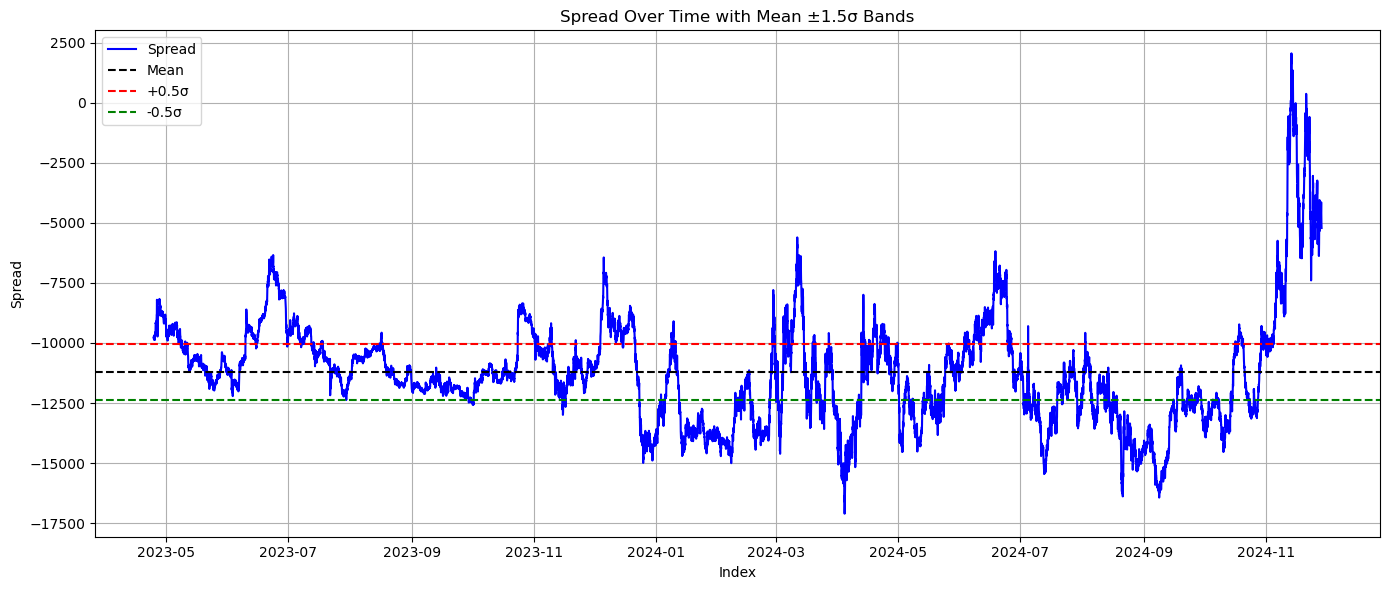

In [255]:

# Calculate statistics
spread = main_df['SPREAD']
mean = spread.mean()
std = spread.std()
upper = mean + 0.5 * std
lower = mean - 0.5 * std

# Plot
plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='blue')
plt.axhline(mean, color='black', linestyle='--', label='Mean')
plt.axhline(upper, color='red', linestyle='--', label='+0.5σ')
plt.axhline(lower, color='green', linestyle='--', label='-0.5σ')
plt.title('Spread Over Time with Mean ±1.5σ Bands')
plt.xlabel('Index')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [257]:
spread_mean = main_df['SPREAD'].mean()
spread_std = main_df['SPREAD'].std()
main_df['Z_SCORE'] = (main_df['SPREAD'] - spread_mean) / spread_std

In [259]:
coefficients_dict

{'const': -11188.216222527044,
 'SOLUSDT': 99.07842086885631,
 'BNBUSDT': 3.605610918594607,
 'TRXUSDT': 132111.7283173743,
 'NEXOUSDT': 15360.900503781202,
 'PAXGUSDT': 6.43804960617706,
 'BCHUSDT': 17.8677393658903}

In [261]:
#Training Dataset Try

coefficients_array = -np.array(list(coefficients_dict.values()))[1:]  # Eliminate the first value and make all negative
coefficients_array = np.concatenate([coefficients_array, [1]])  # Add 1 as the last value

def buy_sell_spread(row, coef=coefficients_array):
    return np.dot(row[:len(coef)], coef)  # Adjust row slicing to match the number of coefficients

sigma_values = [0.5, 0.75, 1, 1.25, 1.5]
results = []

for sigma in sigma_values:
    total_value = 0
    num_trading = 0
    position = 0  # 0 = no position, 1 = long, -1 = short
    entry_price = 0
    
    for row in main_df.to_numpy():
        z = row[-1]
        spread_val = buy_sell_spread(row)
        
        # If not in a position, open one
        if position == 0:
            if z > sigma:
                position = -1  # open short
                entry_price = spread_val
                num_trading += 1
            elif z < -sigma:
                position = 1  # open long
                entry_price = spread_val
                num_trading += 1
        
        # If in a position, check for exit and reverse
        elif position == 1:  # currently long
            if z > sigma:
                # exit long, enter short
                profit = spread_val - entry_price
                total_value += profit
                entry_price = spread_val
                position = -1
                num_trading += 1
                
        elif position == -1:  # currently short
            if z < -sigma:
                # exit short, enter long
                profit = entry_price - spread_val
                total_value += profit
                entry_price = spread_val
                position = 1
                num_trading += 1
    # Optionally, close final open position (unrealized PnL)
    if position == 1:
        total_value += spread_val - entry_price
    elif position == -1:
        total_value += entry_price - spread_val

    results.append([sigma, total_value, num_trading])

# Display as DataFrame
results_df = pd.DataFrame(results, columns=["Sigma", "Total Value", "Number of Trades"])
print(results_df)


   Sigma   Total Value  Number of Trades
0   0.50  71284.020110                29
1   0.75  64893.808551                19
2   1.00  46505.213400                11
3   1.25  60138.819126                11
4   1.50  44084.887530                 7


In [263]:
import numpy as np
import pandas as pd

# Prepare coefficients
coefficients_array = -np.array(list(coefficients_dict.values()))[1:]
coefficients_array = np.concatenate([coefficients_array, [1]])

def buy_sell_spread(row, coef=coefficients_array):
    return np.dot(row[:len(coef)], coef)

sigma_values = [0.5, 0.75, 1, 1.25, 1.5]
results = []

for sigma in sigma_values:
    trades = []
    cumulative_pnl = []
    total_value = 0
    num_trading = 0
    position = 0
    entry_price = 0

    for row in main_df.to_numpy():
        z = row[-1]
        spread_val = buy_sell_spread(row)

        if position == 0:
            if z > sigma:
                position = -1
                entry_price = spread_val
                num_trading += 1
            elif z < -sigma:
                position = 1
                entry_price = spread_val
                num_trading += 1

        elif position == 1:
            if z > sigma:
                profit = spread_val - entry_price
                trades.append(profit)
                total_value += profit
                cumulative_pnl.append(total_value)
                position = -1
                entry_price = spread_val
                num_trading += 1

        elif position == -1:
            if z < -sigma:
                profit = entry_price - spread_val
                trades.append(profit)
                total_value += profit
                cumulative_pnl.append(total_value)
                position = 1
                entry_price = spread_val
                num_trading += 1

    # Close open position
    if position != 0:
        profit = spread_val - entry_price if position == 1 else entry_price - spread_val
        trades.append(profit)
        total_value += profit
        cumulative_pnl.append(total_value)

    # Stats
    num_trades = len(trades)
    avg_pnl = np.mean(trades) if trades else 0
    max_profit = np.max(trades) if trades else 0
    min_profit = np.min(trades) if trades else 0
    gross_profit = np.sum([t for t in trades if t > 0])
    gross_loss = -np.sum([t for t in trades if t < 0])
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf
    percent_positive = 100 * len([t for t in trades if t > 0]) / num_trades if num_trades else 0
    percent_negative = 100 - percent_positive

    # Max Drawdown
    equity_curve = np.array([0] + cumulative_pnl)
    rolling_max = np.maximum.accumulate(equity_curve)
    drawdowns = rolling_max - equity_curve
    max_drawdown = np.max(drawdowns)
    profit_to_draw = total_value / max_drawdown if max_drawdown != 0 else np.inf

    # Append all results
    results.append([
        sigma, total_value, num_trades, avg_pnl, max_profit, min_profit,
        gross_profit, gross_loss, profit_factor, percent_positive,
        percent_negative, max_drawdown, profit_to_draw
    ])

# Create final DataFrame
columns = [
    "Sigma", "Net P&L", "Num Trades", "Avg Trade P&L", "Max Profit", "Max Loss",
    "Gross Profit", "Gross Loss", "Profit Factor", "% Win", "% Loss",
    "Max Drawdown", "Profit/Drawdown"
]
results_df = pd.DataFrame(results, columns=columns)
print(results_df.round(2))


   Sigma   Net P&L  Num Trades  Avg Trade P&L  Max Profit  Max Loss  \
0   0.50  71284.02          29        2458.07     3267.00  -4777.73   
1   0.75  64893.81          19        3415.46     4389.16  -4090.78   
2   1.00  46505.21          11        4227.75     5366.85  -3598.54   
3   1.25  60138.82          11        5467.17     6676.68  -2502.16   
4   1.50  44084.89           7        6297.84     8038.78  -1859.31   

   Gross Profit  Gross Loss  Profit Factor  % Win  % Loss  Max Drawdown  \
0      76061.75     4777.73          15.92  96.55    3.45       4777.73   
1      68984.59     4090.78          16.86  94.74    5.26       4090.78   
2      50103.76     3598.54          13.92  90.91    9.09       3598.54   
3      62640.98     2502.16          25.03  90.91    9.09       2502.16   
4      45944.20     1859.31          24.71  85.71   14.29       1859.31   

   Profit/Drawdown  
0            14.92  
1            15.86  
2            12.92  
3            24.03  
4            23.7

In [265]:
#Test Set Try

main_df_test['SPREAD'] = (
    main_df_test['BTCUSDT']
    - coefficients["SOLUSDT"] * main_df_test["SOLUSDT"]
    - coefficients["BNBUSDT"] * main_df_test["BNBUSDT"]
    - coefficients["TRXUSDT"] * main_df_test["TRXUSDT"]
    - coefficients["NEXOUSDT"] * main_df_test["NEXOUSDT"]
    - coefficients["PAXGUSDT"] * main_df_test["PAXGUSDT"]
    - coefficients["BCHUSDT"] * main_df_test["BCHUSDT"]

)

main_df_test['Z_SCORE'] = (main_df_test['SPREAD'] - spread_mean) / spread_std

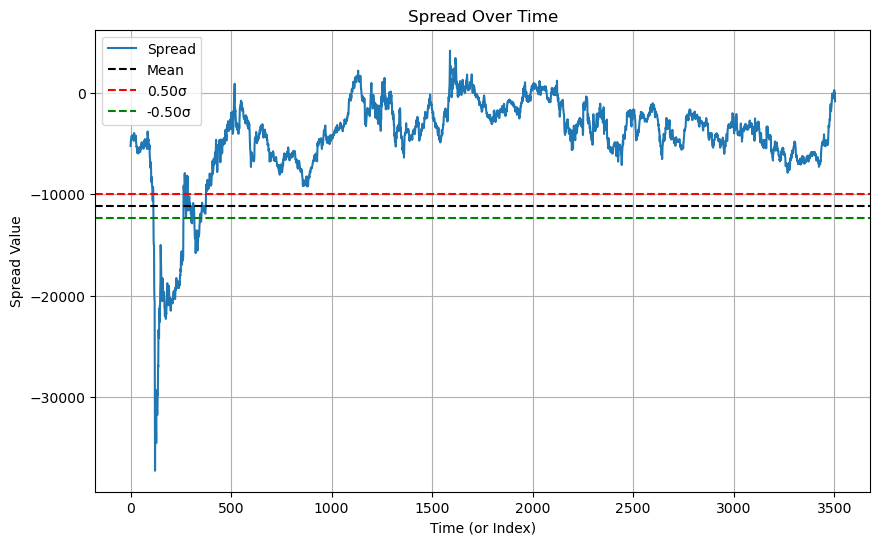

In [267]:
import matplotlib.pyplot as plt

sigma = 0.5
results = []

total_value = 0
num_trading = 0
position = 0  # 0 = no position, 1 = long, -1 = short
entry_price = 0

# List to hold the spread values over time for plotting
spread_values = []

for row in main_df_test.to_numpy():
    z = row[-1]
    spread_val = buy_sell_spread(row)
    
    # Store spread values for plotting
    spread_values.append(spread_val)
    
    # If not in a position, open one
    if position == 0:
        if z > sigma:
            position = -1  # open short
            entry_price = spread_val
            num_trading += 1
        elif z < -sigma:
            position = 1  # open long
            entry_price = spread_val
            num_trading += 1
    
    # If in a position, check for exit and reverse
    elif position == 1:  # currently long
        if z > sigma:
            # exit long, enter short
            profit = spread_val - entry_price
            total_value += profit
            entry_price = spread_val
            position = -1
            num_trading += 1
            
    elif position == -1:  # currently short
        if z < -sigma:
            # exit short, enter long
            profit = entry_price - spread_val
            total_value += profit
            entry_price = spread_val
            position = 1
            num_trading += 1

# Optionally, close final open position (unrealized PnL)
if position == 1:
    total_value += spread_val - entry_price
elif position == -1:
    total_value += entry_price - spread_val

results.append([sigma, total_value, num_trading])

# Display as DataFrame
results_df = pd.DataFrame(results, columns=["Sigma", "Total Value", "Number of Trades"])

# Plot the spread graph
plt.figure(figsize=(10, 6))
plt.plot(spread_values, label="Spread")
plt.axhline(mean, color='black', linestyle='--', label='Mean')
plt.axhline(mean + 0.5 * spread_std, color='red', linestyle='--', label='0.50σ')
plt.axhline(mean - 0.5 * spread_std, color='green', linestyle='--', label='-0.50σ')
plt.title("Spread Over Time")
plt.xlabel("Time (or Index)")
plt.ylabel("Spread Value")
plt.legend()
plt.grid(True)
plt.show()


In [269]:
results_df

,Sigma,Total Value,Number of Trades
0,0.5,19057.944259,7


In [271]:
import pandas as pd
import numpy as np

# Initialize
sigma_values = [0.25, 0.50, 1, 1.25, 1.5]
results = []

# Make a safe copy
main_df_test = main_df_test.copy()

# Ensure columns
if 'SPREAD' not in main_df_test.columns:
    main_df_test['SPREAD'] = np.nan
if 'Z_SCORE' not in main_df_test.columns:
    main_df_test['Z_SCORE'] = np.nan

# Iterate sigma
for sigma in sigma_values:
    total_value = 0
    num_trading = 0
    position = 0
    entry_price = 0
    
    spread_mean = 0
    M2 = 0
    count = 0
    last_spread = 0

    for idx, row in main_df_test.iterrows():
        # Calculate spread
        spread = (row['BTCUSDT'] 
                  - coefficients["SOLUSDT"] * row["SOLUSDT"]
                  - coefficients["BNBUSDT"] * row["BNBUSDT"]
                  - coefficients["TRXUSDT"] * row["TRXUSDT"]
                  - coefficients["NEXOUSDT"] * row["NEXOUSDT"]
                  - coefficients["PAXGUSDT"] * row["PAXGUSDT"]
                  - coefficients["BCHUSDT"] * row["BCHUSDT"]
                 )
        
        # Update stats (Welford)
        count += 1
        delta = spread - spread_mean
        spread_mean += delta / count
        delta2 = spread - spread_mean
        M2 += delta * delta2
        
        if count > 1:
            spread_std = np.sqrt(M2 / (count - 1))
        else:
            spread_std = 1e-6  # avoid division by zero
        
        # Calculate z
        z = (spread - spread_mean) / spread_std
        
        main_df_test.at[idx, 'SPREAD'] = spread
        main_df_test.at[idx, 'Z_SCORE'] = z
        
        # Trading logic
        if position == 0:
            if z > sigma:
                position = -1
                entry_price = spread
                num_trading += 1
            elif z < -sigma:
                position = 1
                entry_price = spread
                num_trading += 1
        elif position == 1:
            if z > sigma:
                profit = spread - entry_price
                total_value += profit
                entry_price = spread
                position = -1
                num_trading += 1
        elif position == -1:
            if z < -sigma:
                profit = entry_price - spread
                total_value += profit
                entry_price = spread
                position = 1
                num_trading += 1
        
        last_spread = spread

    # Close final position
    if position == 1:
        total_value += last_spread - entry_price
    elif position == -1:
        total_value += entry_price - last_spread

    results.append([sigma, total_value, num_trading])

# Output
results_df = pd.DataFrame(results, columns=["Sigma", "Total Value", "Number of Trades"])
print(results_df)


   Sigma   Total Value  Number of Trades
0   0.25  22679.740395                25
1   0.50   3322.323627                13
2   1.00  -2356.866873                 5
3   1.25   4481.906854                 5
4   1.50   9785.814788                 5


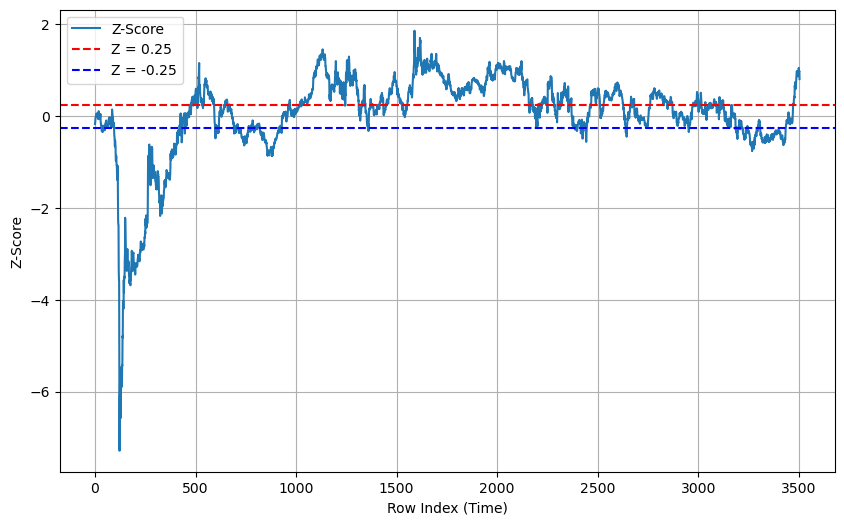

In [275]:
import matplotlib.pyplot as plt
import numpy as np

# List to store the Z-scores
z_scores = []

# Calculate Z-scores for each row
for row in main_df_test.to_numpy():
    # Calculate the spread for the current row
    spread = (row[main_df_test.columns.get_loc('BTCUSDT')] 
              - coefficients["SOLUSDT"] * row[main_df_test.columns.get_loc("SOLUSDT")]
              - coefficients["BNBUSDT"] * row[main_df_test.columns.get_loc("BNBUSDT")]
              - coefficients["TRXUSDT"] * row[main_df_test.columns.get_loc("TRXUSDT")]
              - coefficients["NEXOUSDT"] * row[main_df_test.columns.get_loc("NEXOUSDT")]
              - coefficients["PAXGUSDT"] * row[main_df_test.columns.get_loc("PAXGUSDT")]
              - coefficients["BCHUSDT"] * row[main_df_test.columns.get_loc("BCHUSDT")]
             )
    
    # Append the calculated spread value to the list
    spread_values.append(spread)
    
    # Calculate the dynamic mean and std for spread
    spread_mean = np.mean(spread_values)
    spread_std = np.std(spread_values)
    
    # Calculate Z-score for the current row
    z_score = (spread - spread_mean) / spread_std
    
    # Append the Z-score to the list
    z_scores.append(z_score)

# Plot the Z-scores
plt.figure(figsize=(10, 6))
plt.plot(z_scores, label='Z-Score')

# Add horizontal lines at y=0.75 and y=-0.75
plt.axhline(y=0.25, color='r', linestyle='--', label='Z = 0.25')
plt.axhline(y=-0.25, color='b', linestyle='--', label='Z = -0.25')

# Add title and labels

plt.xlabel('Row Index (Time)')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


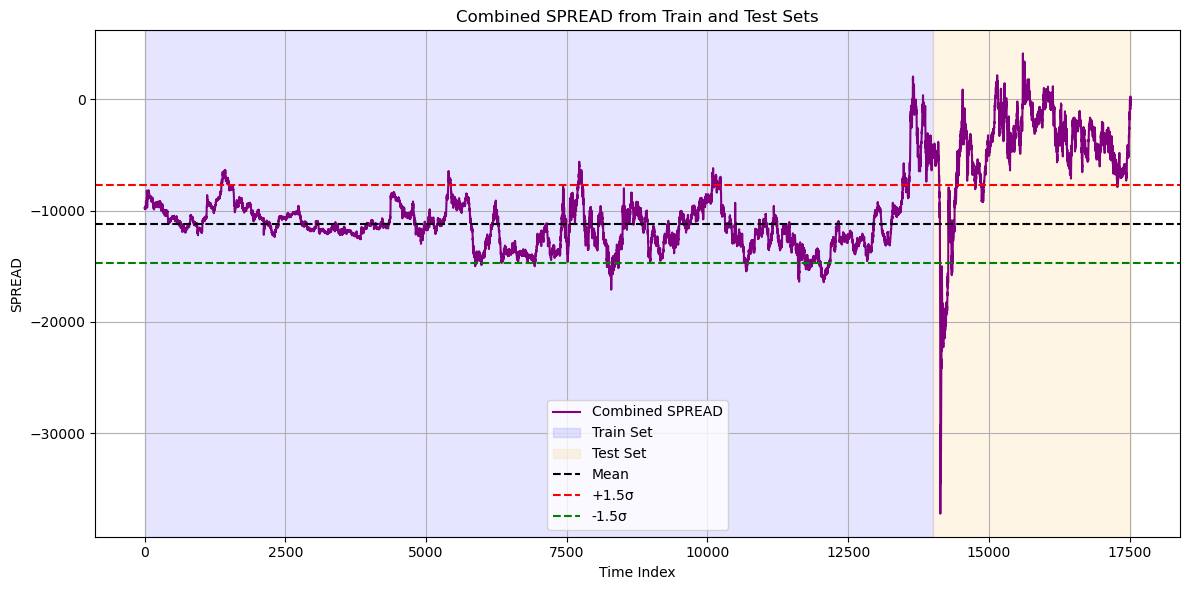

In [227]:
import matplotlib.pyplot as plt

# Calculate stats
spread = main_df['SPREAD']
mean = spread.mean()
std = spread.std()
upper = mean + 1.5 * std
lower = mean - 1.5 * std

# Combine spread for full plot
combined_spread = pd.concat([main_df['SPREAD'], main_df_test['SPREAD']], ignore_index=True)

# Lengths for highlighting
train_len = len(main_df)
test_len = len(main_df_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined_spread, color='purple', label='Combined SPREAD')

# Highlight train/test
plt.axvspan(0, train_len - 1, color='blue', alpha=0.1, label='Train Set')
plt.axvspan(train_len, train_len + test_len - 1, color='orange', alpha=0.1, label='Test Set')

# Add mean and bounds
plt.axhline(mean, color='black', linestyle='--', label='Mean')
plt.axhline(upper, color='red', linestyle='--', label='+1.5σ')
plt.axhline(lower, color='green', linestyle='--', label='-1.5σ')

# Labels and legend
plt.title('Combined SPREAD from Train and Test Sets')
plt.xlabel('Time Index')
plt.ylabel('SPREAD')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
